# Zugriffsdaten-Analyse

In diesem Notebook analysieren wir eine Logdatei mit Zugriffsdaten eines Webserver von einem iranischen Online-Shop. Wir wollen anhand der Zugriffsdaten herausfinden, welche Produkte des Online-Shops am beliebtesten sind. Außerdem untersuchen wir die Daten auf weitere Auffälligkeiten.

## Setup

Als erstes verbinden wir uns mit dem Spark Master Node. Den erreichen wir unter der URL `spark://localhost:7077`.

In [38]:
import pyspark
import pandas as pd
from pyspark.sql.functions import *

spark = pyspark.sql.SparkSession.builder \
  .appName("main") \
  .master("spark://localhost:7077") \
  .getOrCreate()


print(spark.version)

22/07/03 15:53:37 WARN Utils: Your hostname, robin-desktop resolves to a loopback address: 127.0.1.1; using 192.168.2.100 instead (on interface enp0s31f6)
22/07/03 15:53:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/07/03 15:53:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


3.2.1


## Datenimport

Als nächstes importieren wir die Datei `access.log`.

In [2]:
raw_df = spark.read.csv("/tmp/data/access.log", sep=" ")

In [3]:
raw_df.count()

10365152

In [4]:
raw_df.rdd.getNumPartitions()

27

In [5]:
old_value = pd.get_option("display.max_colwidth")
pd.set_option("display.max_colwidth", None)

In [6]:
raw_df.limit(10).toPandas()

,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,_c10
0,54.36.149.41,-,-,[22/Jan/2019:03:56:14,+0330],"GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C%DA%A9%D8%B3%D9%84,27|%DA%A9%D9%85%D8%AA%D8%B1%20%D8%A7%D8%B2%205%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C%DA%A9%D8%B3%D9%84,p53 HTTP/1.1",200,30577,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http://ahrefs.com/robot/),-
1,31.56.96.51,-,-,[22/Jan/2019:03:56:16,+0330],GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,"Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build/HuaweiALE-L21) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.158 Mobile Safari/537.36",-
2,31.56.96.51,-,-,[22/Jan/2019:03:56:16,+0330],GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,"Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build/HuaweiALE-L21) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.158 Mobile Safari/537.36",-
3,40.77.167.129,-,-,[22/Jan/2019:03:56:17,+0330],GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm),-
4,91.99.72.15,-,-,[22/Jan/2019:03:56:17,+0330],GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%D8%B1-%D8%AE%D8%A7%D9%86%DA%AF%DB%8C-%D9%BE%D8%B1%D9%86%D8%B3%D9%84%DB%8C-%D9%85%D8%AF%D9%84-PR257AT HTTP/1.1,200,41483,-,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16.0)Gecko/16.0 Firefox/16.0,-
5,40.77.167.129,-,-,[22/Jan/2019:03:56:17,+0330],GET /image/23488/productModel/150x150 HTTP/1.1,200,2654,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm),-
6,40.77.167.129,-,-,[22/Jan/2019:03:56:18,+0330],GET /image/45437/productModel/150x150 HTTP/1.1,200,3688,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm),-
7,40.77.167.129,-,-,[22/Jan/2019:03:56:18,+0330],GET /image/576/article/100x100 HTTP/1.1,200,14776,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm),-
8,66.249.66.194,-,-,[22/Jan/2019:03:56:18,+0330],"GET /filter/b41,b665,c150%7C%D8%A8%D8%AE%D8%A7%D8%B1%D9%BE%D8%B2,p56 HTTP/1.1",200,34277,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html),-
9,40.77.167.129,-,-,[22/Jan/2019:03:56:18,+0330],GET /image/57710/productModel/100x100 HTTP/1.1,200,1695,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm),-


In [7]:
pd.set_option("display.max_colwidth", old_value)

In [8]:
raw_df.select("_c1").groupBy("_c1").count().limit(5).toPandas()

_c1     count
0   -  10365152

In [9]:
raw_df.select("_c2").groupBy("_c2").count().limit(5).toPandas()

_c2     count
0      -  10365150
1  admin         2

In [10]:
raw_df.select("_c10").groupBy("_c10").count().limit(10).toPandas()

,_c10,count
0,5.160.222.39,7
1,10.16.209.128,1
2,5.120.126.172,9
3,5.125.28.183,14
4,79.127.0.178,4
5,37.129.253.117,16
6,5.112.157.124,2
7,78.38.193.27,3
8,5.235.199.183,65
9,83.123.163.193,18


In [11]:
pd.set_option('display.max_rows', 100)
pd.set_option("display.max_colwidth", 100)
df.filter(~df["method"].isin(["GET","POST","CONNECT","HEAD","OPTIONS"])).limit(100).toPandas()
raw_df.select("_c10") \
    .groupBy("_c10") \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(5) \
    .toPandas()

ip user             timestamp timezone status bytes_sent  \
0       74.82.60.74       22/Jan/2019:08:27:26    +0330    400        166   
1      80.82.64.127       22/Jan/2019:08:40:11    +0330    400        166   
2      72.52.125.78       22/Jan/2019:09:55:32    +0330    400        166   
3    108.178.16.154       22/Jan/2019:14:32:00    +0330    400        166   
4      64.62.197.65       22/Jan/2019:18:04:50    +0330    400        166   
5      64.62.197.65       22/Jan/2019:18:04:50    +0330    400        166   
6       74.82.60.72       22/Jan/2019:19:31:13    +0330    400        166   
7      5.188.210.12       22/Jan/2019:23:05:04    +0330    400        166   
8      5.188.210.12       22/Jan/2019:23:06:22    +0330    400        166   
9     66.240.205.34       23/Jan/2019:03:09:34    +0330    400        166   
10    66.160.199.78       23/Jan/2019:03:52:09    +0330    400        166   
11    94.183.88.223       23/Jan/2019:11:10:38    +0330    400          0   
12    94.183.88.223       23/Jan/2019:11:10:41    +0330    400          0   
13    94.183.88.223       23/Jan/2019:11:11:00    +0330    400          0   
14    94.183.88.223       23/Jan/2019:11:12:15    +0330    400          0   
15      74.82.17.87       23/Jan/2019:11:53:42    +0330    400        166   
16      74.82.17.87       23/Jan/2019:11:55:26    +0330    400        166   
17      74.82.60.66       23/Jan/2019:12:07:16    +0330    400        166   
18      74.82.60.85       23/Jan/2019:12:43:24    +0330    400        166   
19      74.82.60.85       23/Jan/2019:12:43:27    +0330    400        166   
20      74.82.60.85       23/Jan/2019:12:47:00    +0330    400        166   
21    66.160.178.90       23/Jan/2019:19:06:38    +0330    400        166   
22   185.222.211.18       23/Jan/2019:21:01:08    +0330    400        166   
23     72.52.125.79       23/Jan/2019:21:31:31    +0330    400        166   
24     64.62.197.31       23/Jan/2019:22:43:20    +0330    400        166   
25    202.96.155.48       24/Jan/2019:01:20:02    +0330    301        178   
26    102.165.52.19       24/Jan/2019:01:21:49    +0330    400        166   
27    102.165.52.19       24/Jan/2019:01:21:49    +0330    400        166   
28   34.221.219.207       24/Jan/2019:06:57:45    +0330    400        166   
29    123.206.9.252       24/Jan/2019:09:50:31    +0330    301        178   
30       74.82.4.78       24/Jan/2019:10:36:55    +0330    400        166   
31       74.82.4.78       24/Jan/2019:10:41:34    +0330    400        166   
32      72.52.87.84       24/Jan/2019:10:51:17    +0330    400        166   
33     52.53.248.70       24/Jan/2019:11:26:18    +0330    400        166   
34     64.71.174.32       24/Jan/2019:12:43:55    +0330    400        166   
35     64.71.174.32       24/Jan/2019:12:43:59    +0330    400        166   
36    102.165.52.19       24/Jan/2019:13:25:44    +0330    400        166   
37    102.165.52.19       24/Jan/2019:13:25:44    +0330    400        166   
38   188.210.165.90       24/Jan/2019:14:06:56    +0330    400          0   
39   208.85.211.218       24/Jan/2019:16:06:52    +0330    400        166   
40  149.202.169.246       25/Jan/2019:05:47:45    +0330    400        166   
41  149.202.169.246       25/Jan/2019:05:47:46    +0330    400        166   
42      72.52.87.60       25/Jan/2019:07:14:40    +0330    400        166   
43      72.52.87.60       25/Jan/2019:07:16:55    +0330    400        166   
44     190.85.81.27       25/Jan/2019:08:46:07    +0330    301        178   
45     5.188.210.12       25/Jan/2019:09:10:31    +0330    400        166   
46     5.188.210.12       25/Jan/2019:09:12:12    +0330    400        166   
47     185.53.88.19       25/Jan/2019:13:48:00    +0330    400        166   
48     185.53.88.19       25/Jan/2019:13:48:00    +0330    400        166   
49     185.209.0.12       26/Jan/2019:00:28:34    +0330    400        166   
50     64.71.174.85       26/Jan/2019:01:25:01    +0330    400        166   

   referer u

Die Kopfzeile der `DataFrame`-Tabelle enthält noch keine sinnvollen Bezeichnungen. Das wollen wir jetzt ändern.

Die Logdatei befindet sich im Format eines Apache-Standards: https://httpd.apache.org/docs/2.4/logs.html

In [42]:
df = raw_df.withColumnRenamed("_c0", "ip") \
  .drop("_c1") \
  .withColumnRenamed("_c2", "user") \
  .withColumnRenamed("_c3", "timestamp") \
  .withColumnRenamed("_c4", "timezone") \
  .withColumnRenamed("_c5", "request_line") \
  .withColumnRenamed("_c6", "status") \
  .withColumnRenamed("_c7", "bytes_sent") \
  .withColumnRenamed("_c8", "referer") \
  .withColumnRenamed("_c9", "user_agent") \
  .withColumnRenamed("_c10", "unknown_ip")

In [43]:
df.limit(5).toPandas()

,ip,user,timestamp,timezone,request_line,status,bytes_sent,referer,user_agent,unknown_ip
0,54.36.149.41,-,[22/Jan/2019:03:56:14,+0330],GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,-
1,31.56.96.51,-,[22/Jan/2019:03:56:16,+0330],GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,-
2,31.56.96.51,-,[22/Jan/2019:03:56:16,+0330],GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,-
3,40.77.167.129,-,[22/Jan/2019:03:56:17,+0330],GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,-
4,91.99.72.15,-,[22/Jan/2019:03:56:17,+0330],GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,-,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,-


Dann sollten wir noch die Inhalte innerhalb der Zellen bereinigen. Momentan werden leere Zellen mit einem Bindestrich gekennzeichnet. Wir wollen diese Bindestriche entfernen. Außerdem enthalten die Zellen der Spalten `timestamp` und `timezone` unnötige Symbole. Diese wollen wir auch entfernen.

In [44]:
df = df.withColumn("user", regexp_replace("user", "-", "")) \
  .withColumn("timestamp", regexp_replace("timestamp", "^\[", "")) \
  .withColumn("timezone", regexp_replace("timezone", "\]$", "")) \
  .withColumn("referer", regexp_replace("referer", "-", ""))

In [45]:
df.limit(5).toPandas()

,ip,user,timestamp,timezone,request_line,status,bytes_sent,referer,user_agent,unknown_ip
0,54.36.149.41,,22/Jan/2019:03:56:14,+0330,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,-
1,31.56.96.51,,22/Jan/2019:03:56:16,+0330,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,-
2,31.56.96.51,,22/Jan/2019:03:56:16,+0330,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,-
3,40.77.167.129,,22/Jan/2019:03:56:17,+0330,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,-
4,91.99.72.15,,22/Jan/2019:03:56:17,+0330,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,-


Uns fällt auf, dass die Spalte `request_line` in zwei Spalten aufgeteilt werden kann. Sie enthält nämlich zum einen die Information darüber, welche HTTP-Methode in einer Anfrage verwendet wurde, und zum anderen den URL-Pfad mit Query-Parametern. Wir wollen die Spalte `request_line` in die Spalten `method` und `request_path` aufteilen.

In [46]:
request_line_split = split(df.request_line, " ")
df = df.withColumn("method", request_line_split.getItem(0)) \
  .withColumn("request_path", request_line_split.getItem(1))

In [47]:
df.select("request_line", "method", "request_path").limit(5).toPandas()

,request_line,method,request_path
0,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,GET,/filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...
1,GET /image/60844/productModel/200x200 HTTP/1.1,GET,/image/60844/productModel/200x200
2,GET /image/61474/productModel/200x200 HTTP/1.1,GET,/image/61474/productModel/200x200
3,GET /image/14925/productModel/100x100 HTTP/1.1,GET,/image/14925/productModel/100x100
4,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,GET,/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...


In [48]:
pd.set_option('display.max_rows', 10)
pd.set_option("display.max_colwidth", old_value)

## Beliebteste Produkte

Wir gehen von der Annahme aus, dass die Beliebtheit eines Produkts von der Anzahl der Anfragen an das Produkt abgeleitet werden kann. Diese Metrik kann zwar leicht durch äußere Einwirkungen manipuliert werden, aber diese Tatsache ignorieren wir im Rahmen dieser Aufgabe.

Als erstes wollen wir herausfinden, welche Anfragen auf ein bestimmtes Produkt bezogen sind. Dafür fügen wir in unserem `DataFrame` eine weitere Spalte `product_id` hinzu, in der die Produkt-ID der Anfragen steht, die einen Anfragepfad im Schema `/product/<product-id>` besitzen.

In [49]:
df = df.withColumn("product_id", regexp_extract("request_path", r'^/product/(\d+)', 1))

In [51]:
df.select("request_path", "product_id").filter(df.product_id != "").limit(10).toPandas()

,request_path,product_id
0,/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...,31893
1,/product/10214,10214
2,/product/10075/13903/%D9%85%D8%A7%DB%8C%DA%A9%...,10075
3,/product/14926,14926
4,/product/32798/63266/%DB%8C%D8%AE%DA%86%D8%A7%...,32798
5,/product/30649?model=60398,30649
6,/product/7793/9663/%D9%85%D8%A7%DB%8C%DA%A9%D8...,7793
7,/product/81900,81900
8,/product/4057/47/78306,4057
9,/product/29080?model=58289,29080


Wenn wir jetzt die Zeilen der Tabelle nach der der Produkt-ID gruppieren, die Anzahl der Reihen für jede Gruppe berechnen und die Gruppen nach dieser Anzahl sortieren, können wir die Anzahl der Anfragen für jedes Produkt auslesen.

In [52]:
product_group_df = df.filter(df.product_id != "").groupBy("product_id").count().sort(col("count").desc()).limit(100).toPandas()

In [74]:
product_group_df.shape
product_group_df = df.filter(df.product_id != "") \
    .groupBy("product_id").count() \
    .sort(col("count").desc()) \
    .limit(50).toPandas()

(50, 2)

In [54]:
product_group_df.head()

,product_id,count
0,33953,764
1,34286,738
2,33968,693
3,33954,687
4,33956,594


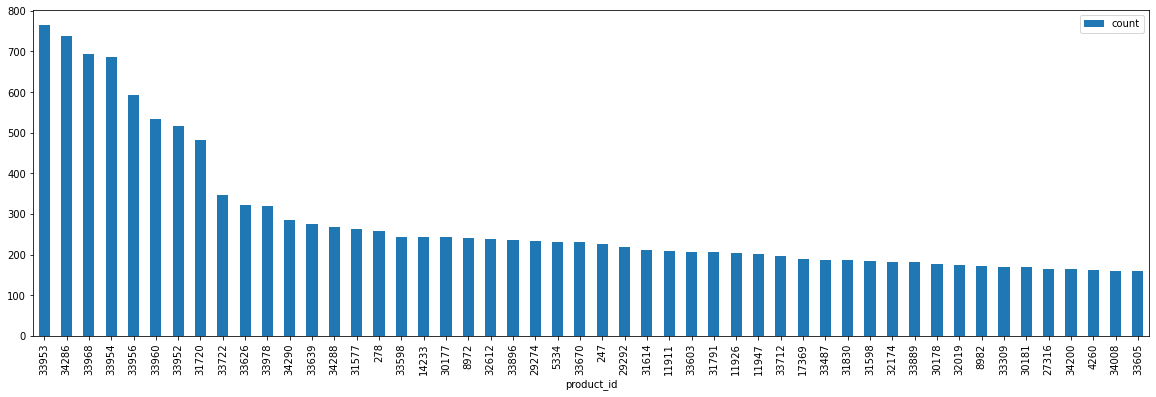

In [55]:
product_group_df.plot.bar(figsize=(20, 6), x="product_id")

## Weitere Auffälligkeiten

Jetzt wollen wir den Datensatz auf weitere Auffälligkeiten untersuchen.

### URL-Pfad-Längen

HTTP-Anfragen, die sehr lange Pfade enthalten, können für den Webserver eventuell problematisch sein, weil deren Verarbeitung hohen Rechenaufwand erzeugt.

Wir wollen deshalb herausfinden, ob der Webserver des Online-Shops Anfragen erhält, die ungewöhnlich lange Pfade enthalten. Dazu fügen wir eine neue Spalte im `DataFrame` hinzu, die mit der Anzahl der Zeichen des Pfades in der jeweiligen Zeile gefüllt wird.

In [56]:
df = df.withColumn("request_path_length", length("request_path"))

Jetzt sortieren wir die Zeilen abfallend nach der Pfadlänge, um die Anfragen mit den längsten Pfaden auslesen zu können.

In [57]:
pandas_df = df.select("ip", "method", "request_path", "status", "request_path_length") \
  .sort(df.request_path_length.desc()) \
  .limit(20) \
  .toPandas()

In [58]:
pandas_df

,ip,method,request_path,status,request_path_length
0,5.78.190.233,GET,/rapidGrails/jsonList?maxColumns=10&domainClas...,414,8188
1,91.99.47.57,GET,/rapidGrails/jsonList?maxColumns=10&domainClas...,414,8188
2,91.99.30.32,GET,/rapidGrails/jsonList?maxColumns=10&domainClas...,414,8188
3,91.99.30.32,GET,/rapidGrails/jsonList?maxColumns=10&domainClas...,414,8188
4,5.117.116.238,GET,/rapidGrails/jsonList?maxColumns=10&domainClas...,414,8188
5,91.99.30.32,GET,/rapidGrails/jsonList?maxColumns=10&domainClas...,414,8188
6,91.99.47.57,GET,/rapidGrails/jsonList?maxColumns=10&domainClas...,414,8188
7,151.239.241.163,GET,/rapidGrails/jsonList?maxColumns=10&domainClas...,414,8188
8,91.99.30.32,GET,/rapidGrails/jsonList?maxColumns=10&domainClas...,414,8188
9,5.117.116.238,GET,/rapidGrails/jsonList?maxColumns=10&domainClas...,414,8188


Wir sehen, dass die meisten Anfragen mit den längsten Pfaden zur Route `/rapidGrails/...` gehören. Die Route wird anscheinend von dem Java Plugin „Grails“ genutzt, um große JSON-ähnlichen Datenmengen über die Query-Parameter einer `GET`-Anfrage an den Server zu übertragen. Einige dieser Anfragen wurden vom Webserver mit dem Fehlercode 414 („URI Too Long“) beantwortet. Um das Problem zu lösen, könnte man das Plugin eventuell so konfigurieren, dass die Daten im Body einer `POST`-Anfrage übertragen werden, anstatt dies über die Query-Parameter einer `GET`-Anfrage zu tun.

Jetzt wollen wir herausfinden, welche anderen Anfragen es neben denen des fehlerhaften Plugins noch gibt, die ebenfalls überdurchschnittlich lange Pfade enthalten. Dazu führen wir die Sortierung nach Pfadlänge ein weiteres Mal durch, aber ignorieren diesmal alle Pfade mit dem Schema `/rapidGrails/...`.

In [74]:
pandas_df = df.select("ip", "method", "request_path", "status", "request_path_length") \
  .filter(~df.request_path.rlike(r'^/rapidGrails/')) \
  .sort(df.request_path_length.desc()) \
  .limit(20) \
  .toPandas()

In [75]:
pandas_df

,ip,method,request_path,status,request_path_length
0,79.175.173.155,GET,/message/receive?Destination=982142328&Source=...,301,2051
1,79.175.173.155,GET,/message/receive?Destination=982142328&Source=...,301,2051
2,79.175.173.155,GET,/message/receive?Destination=982142328&Source=...,301,2051
3,79.175.173.155,GET,/message/receive?Destination=982142328&Source=...,301,2051
4,79.175.173.155,GET,/message/receive?Destination=982142328&Source=...,200,2051
5,79.175.173.155,GET,/message/receive?Destination=982142328&Source=...,200,2051
6,79.175.173.155,GET,/message/receive?Destination=982142328&Source=...,301,2051
7,79.175.173.155,GET,/message/receive?Destination=982142328&Source=...,200,2051
8,79.175.173.155,GET,/message/receive?Destination=982142328&Source=...,200,2051
9,79.175.173.155,GET,/message/receive?Destination=982142328&Source=...,200,2051


Wie wir sehen, sind auch die Pfade der Anfragen an die Route `/message/...` relativ lang. Schauen wir uns einen dieser Pfade mal genauer an:

In [76]:
pandas_df.iloc[10].request_path

'/message/receive?Destination=982142328&Source=989124309589&ReceiveTime=1548483681.619&MsgBody=%D8%A7%DB%8C%D9%86%D8%AC%D8%A7%D9%86%D8%A8+%D9%85%D8%AD%D9%85%D8%AF+%D9%85%D9%87%D8%AF%DB%8C+%D8%B9%D9%84%DB%8C+%D9%86%D9%82%DB%8C%D8%A7%D9%86+%D8%A8%D8%A7+%D9%83%D8%AF+%D8%B1%D9%87%DA%AF%DB%8C%D8%B1%DB%8C+9711050958%D8%A8%D8%A7+%D8%A2%DA%AF%D8%A7%D9%87%DB%8C+%D9%83%D8%A7%D9%85%D9%84+%D8%A7%D8%B2+%D8%A7%DB%8C%D9%86%D9%83%D9%87+%D8%A2%D8%A8%DA%AF%D8%B1%D9%85%D9%83%D9%86+%D8%AE%D8%B1%DB%8C%D8%AF%D8%A7%D8%B1%DB%8C+%D8%B4%D8%AF%D9%87+%D9%85%D8%AA%D9%86%D8%A7%D8%B3%D8%A8+%D8%A8%D8%A7+%D9%81%D8%B6%D8%A7%DB%8C+%D9%85%D8%AD%D9%84+%D9%86%D8%B5%D8%A8+%D8%A2%D9%86+%D8%A7%D8%B3%D8%AA+%D9%88+%D9%83%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3%D8%A7%D9%86+%D8%B4%D8%B1%D9%83%D8%AA+%D9%85%D8%B1%D8%A8%D9%88%D8%B7%D9%87+%28%D8%B4%D8%B1%D9%83%D8%AA+%D8%A7%D8%B1%D8%A7%D8%A6%D9%87+%D8%AF%D9%87%D9%86%D8%AF%D9%87+%D8%AE%D8%AF%D9%85%D8%A7%D8%AA+%DA%AF%D8%A7%D8%B1%D8%A7%D9%86%D8%AA%DB%8C%29+%D9%86%DB%8C%D8%B2+%D8%A2%D9%86+%D8

In [73]:
import urllib.parse
print(urllib.parse.unquote_plus(pandas_df.iloc[10].request_path.split("MsgBody=")[1]))

اینجانب محمد مهدی علی نقیان با كد رهگیری 9711050958با آگاهی كامل از اینكه آبگرمكن خریداری شده متناسب با فضای محل نصب آن است و كارشناسان شركت مربوطه (شركت ارائه دهنده خدمات گارانتی) نیز آن را تایید نموده اند، اقدام به خرید نموده و مطلع هستم آبگرمكن فوق ، تحت هیچ شرایطی (غیر از مواردی كه دستگاه دارای ایراد فنی باشد كه به تائید كارشناس شركت خدمات رسیده باشد) امكان تعویض یا مرجوع نمودن ندارد


In dem Query-Parameter `MsgBody` wird eine persönliche Nachricht (iranisch und URL-kodiert) an einen Kunden des Online-Shops übermittelt. Diese Nachricht könnte eventuell sensible Informationen enthalten und sollte definitiv nicht im Query-String der URL enthalten sein. Stattdessen sollte für diese Funktion eine `POST`-Anfrage verwendet werden, die die zu übermittelnde Nachricht im Body enthält. So ließe sich verhindern, dass sensible Daten in einer Logdatei aufgezeichnet und dadurch leicht an unautorisierte Personen gelangen können.

## Hacking Angriffe

Jetzt schauen wir uns noch an, welche HTTP-Methoden von den Anfragen in den Zugriffsdaten verwendet werden: 

In [77]:
df.select("method") \
    .groupBy("method").count() \
    .limit(100).toPandas()

,method,count
0,\x17\x10\x05\x15JL\xAD\xDC\xCEL\xC1Ff>F,1
1,OPTIONS,1424
2,POST,139155
3,HEAD,34501
4,GET,10190005
5,\x16\x03\x01\x00\x96\x01\x00\x00\x92\x03\x03\x...,1
6,\x13BitTorrent,1
7,CONNECT,10
8,j\x00\xA7\x00\xF3\x00H\x00z\x00\xF3\x00\xFE\x0...,1
9,\x05bE\x00\x05b\x00\x00@\x00;\x11\x0F\xAC\xD8:...,1


Wie zu erwarten, verwenden die meisten Anfragen die bekannten Methoden des HTTP-Standards: `GET`, `POST`, `OPTIONS`, `CONNECT`, `HEAD` und `PROPFIND`.

Es gibt allerdings auch Anfragen, die statt der Bezeichnung einer Methode seltsame Byte-Folgen enthalten. Wir haben herausgefunden, dass einige dieser Anfragen Hacking-Versuche sind (Quelle: https://security.stackexchange.com/questions/51904/nginx-hacking-attempt). Das lässt sich bei öffentlichen Servern leider nicht verhindern. Wenn der Server diese Anfragen aber blockiert, indem er sie mit einem Fehler-Code beantwortet, können diese Angriffe bedenkenlos ignoriert werden.

Als letztes wollen wir deshalb noch herausfinden, mit welchen Status-Codes der Server diese Angriffe beantwortet.

In [83]:
df.filter(~df["method"].isin(["GET", "POST", "OPTIONS", "HEAD", "CONNECT", "PROPFIND"])) \
    .groupBy("status").count() \
    .limit(10).toPandas()

,status,count
0,400,48


Alle 48 Anfragen, die Methoden verwenden, die nicht im HTTP-Standard enthalten sind, werden ordnungsgemäß mit dem Fehler-Code `400` („Bad Request“) beantwortet. Der Server blockt die Hacking-Versuche also zufriedenstellend ab.